In [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we explored the dataset and obtain insights on what fraction of failures could be prevented by means of predictive replacement. In this notebook we aim to use machine learning techniques in order to judge whether a HDD is close to failure (and should therefore be turned off), or not.

By means of these techniques we aim to determine a good predictive replacement policy. Assume that each HDD working on a certain day give a profit of $1$ unit and that the failure of an HDD yields a cost of $C$ units (where $C \gg 1$). Hence, the revenue on day $t$ is given by 

$$
R_t = A_t - C F_t,
$$

where $A_t$ is the number of HDDs active on day $t$ and $F_t$ is the number of HDDs failing on the same day. We aim to maximize the total revenue in a period of interest $T$, i.e., 

$$
R = \sum_{t \in T} R_t. 
$$

Note that when an HDD is labeled as close to failure by our classification algorithm it will be turned off for good, thus preventing it to produce revenue on the following days. Hence, a trade-off has to be found between turning off HDDs too early or missing to turning them off and incur the failure cost. 

First of all we load the dataframes we saved at the end of [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta



In [2]:
ModelName = 'Hitachi HDS722020ALA330' 

folder_name_model = ModelName.replace(' ', '_')
folder_name = 'Data/' + folder_name_model

df = pd.read_csv(folder_name + '/DataFrame.csv', parse_dates=[1])
df_serialnumber = pd.read_csv(folder_name + '/serialnumber.csv')
df_smartmetrics = pd.read_csv(folder_name + '/smartmetrics.csv')

df_smartmetrics.rename(columns={'Unnamed: 0':'statistic'}, inplace=True)
df_smartmetrics.set_index('statistic')

df_serialnumber.rename(columns={'Unnamed: 0':'serial_number'}, inplace=True)

df.head()

,serial_number,date,failure,smart_1_normalized,smart_5_normalized,smart_7_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_196_normalized,state,D_from_first,D_to_last
0,JK1100B8G3B7AT,2015-01-01,0,100,100,100,100,100,100,100,healthy,0,-602
1,JK1100B8G3B7AT,2015-01-02,0,100,100,100,100,100,100,100,healthy,1,-601
2,JK1100B8G3B7AT,2015-01-03,0,100,100,100,100,100,100,100,healthy,2,-600
3,JK1100B8G3B7AT,2015-01-04,0,100,100,100,100,100,100,100,healthy,3,-599
4,JK1100B8G3B7AT,2015-01-05,0,100,100,100,100,100,100,100,healthy,4,-598


Before starting any learning procedure, we have to split our data in training and test data. However, instead of splitting the main dataframe (df), we apply the splitting procedure on the dataframe df_serialnumber. In this way, the entire time series associated to a specific HDD will be either in the training or the test dataset which has two immediate positive consequences:

- The train and the test dataset are independent.
- We can test the predictive replacement policy obtained analyzing the training dataset on the HDDs belonging to the test dataset.

In [3]:
from sklearn.model_selection import train_test_split

model_X = df_serialnumber['serial_number'].values
model_y = (df_serialnumber['state'] == 'fail').values

model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(model_X, model_y, random_state = 10, stratify = model_y)

training_models = set(model_X_train)

print('We use ' + str(len(model_X_train)) + ' models for training and ' + str(len(model_X_test)) + ' models for testing.\n')

print('The fraction of faining models in the training set is ' + str(np.mean(model_y_train)) + '. In the testing set is ' + str(np.mean(model_y_test)) + '.\n')

training_data_mask = [x in training_models for x in df['serial_number']]
test_data_mask = [not x for x in training_data_mask]

print('Thus, we have ' + str(np.sum(training_data_mask)) + ' observations for training and ' + str(np.sum(test_data_mask)) + ' for testing.\n')

We use 3512 models for training and 1171 models for testing.

The fraction of faining models in the training set is 0.0321753986333. In the testing set is 0.0324508966695.

Thus, we have 1955726 observations for training and 651894 for testing.



The dataframe df can be seen in two different ways:

- An observation consists of a single measure on a specific day.
- An observation consists of the entire time-series associated to a specific HDD.

By using the first approach we keep track of the entire temporal evolution of the SMART metrics but we have a small pool of observations.

By using the second approach we lose the temporal dependence of the entries but we maintain a tremendously larger pool of observations.

In this notebook we aim to explore both approaches. 

The policies deduced will be compared with the total revenue $R$ obtained with only a preventive replacements policy. 

The following function is used to extract the revenue per day. It takes in input:

- C : The cost per failure
- turned_off : The set of HDDs serial_numbers that the policy prescribed to turn off before that day.
- hdds : The list of HDDs observed that day (those active in the original dataset)
- failures : The list of 0/1 capturing whether the observed HDD failed that day

In [4]:
def revenue_per_day(C, turned_off, hdds, failures) :
    '''For a given day, add 1 for every hdd in hdds which do not fail on that day and was not already turned off. Remove 50 if the hdd is on and failed on that day.'''
    revenue = 0
    for ind in range(len(hdds)) : 
        active = hdds[ind] in turned_off
        revenue = revenue + (1 - active)*((1 - failures[ind]) - C*failures[ind])
    return revenue    
        

What shall we expect to gain with a preventive replacement policy as C changes ? 

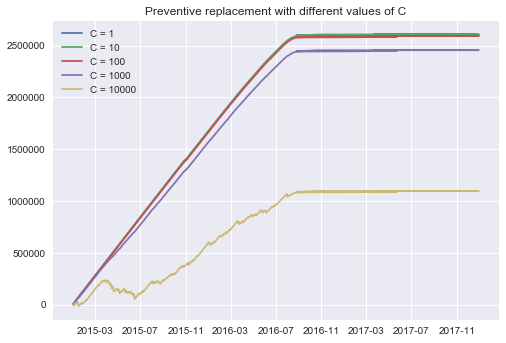

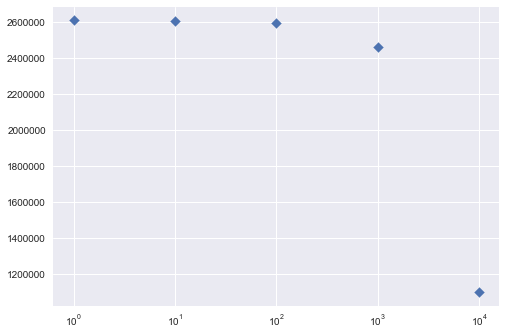

In [9]:
dates = df.date.unique()
Cs = [1, 10, 100, 1000, 10000]
turned_off = set()
total_revenue = []

for C in Cs :
    revenue = []

    for ind, day in enumerate(dates) :
        df_day = df[df['date']==day]
        revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
        # With predictive replacement : Include here the HDDs predicted to fail to the set turned_off
    
    cum_revenue = np.cumsum(revenue)
    total_revenue.append(cum_revenue[-1])

    plt.plot(dates, cum_revenue, label = 'C = {}'.format(C))
    
plt.title('Preventive replacement with different values of C')
plt.legend()
plt.show()        

plt.scatter(x = Cs, y = total_revenue, marker = 'D')
plt.title('Total revenue at the end of the period')
plt.xlabel('C')
plt.ylabel('R')
plt.xscale('log')
plt.show()

## First approach - Daily observations

In order to capture, at least partially, the temporal evolution of the SMART metrics. We now compute the relative differences in the value of the SMART metrics. In particular, for every SMART metric $n$ in the dataframe we include the columns:

- smart_n_normalized_diff1 
- smart_n_normalized_diff2 
- smart_n_normalized_diff7
- smart_n_normalized_diff14 

where the entries in smart_n_normalized_diffk denotes the difference in the SMART metric on that day with respect to k days before. When the data of k days before is not available, we set the value to 0.

In [10]:
differences = [1, 2, 7, 14]
smart_metrics = list(df_smartmetrics.columns[1:].values)

for difference in differences :
    
    df2 = df.groupby('serial_number').diff(periods = difference)
    suff = '_diff' + str(difference)
    
    for smart_metric in smart_metrics :
        new_col = smart_metric + suff
        df[new_col] = df2[smart_metric]
        
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607620 entries, 0 to 2607619
Data columns (total 41 columns):
serial_number                  object
date                           datetime64[ns]
failure                        int64
smart_1_normalized             int64
smart_5_normalized             int64
smart_7_normalized             int64
smart_8_normalized             int64
smart_192_normalized           int64
smart_193_normalized           int64
smart_196_normalized           int64
state                          object
D_from_first                   int64
D_to_last                      int64
smart_1_normalized_diff1       float64
smart_5_normalized_diff1       float64
smart_7_normalized_diff1       float64
smart_8_normalized_diff1       float64
smart_192_normalized_diff1     float64
smart_193_normalized_diff1     float64
smart_196_normalized_diff1     float64
smart_1_normalized_diff2       float64
smart_5_normalized_diff2       float64
smart_7_normalized_diff2       float64
smart

We now need to determine the X (data input) and the y (label) for our machine learning algorithms. 

As for the X value, we aim to use only the SMART metrics measurements to make our predictions. 

As for the y label, we aim to label with a $1$ (close to failure) every HDD we would be happy to turn off after observing the SMART metrics measurements of that day. By this, we mean that we do not want to turn off a HDD who not close to failure, i.e., it could be on for some time and consequently produce revenue.

In our model, we thus need to set a threshold $F$ and label with a $1$ every observation of an HDD which will fail in the following $F$ days. The choice of $F$ should clearly depend on $C$, i.e., $F = F(C)$. In particular, we do not want $F \geq C$ because that would mean turning off HDDs who would produce more revenue than the failure cost. 

However, from the exploratory data analysis performed, we observed that there are no indiction of failure when we are more than 14 days from it, we thus select $F(C)$ as follows

$$
F(C) = \min(C-1, 14)
$$


We now use $F(C)$ and the masks created above to obtain X and y, both for the training and the test HDDs.

In [32]:
C = 1000
F = min(14, C-1)

df['label'] = (df['state'] == 'fail') & (df['D_to_last'] > -F).astype(int)

col_X = [col for col in df.columns if col.startswith('smart')]

X_train = df[col_X].loc[training_data_mask, :].values
X_test = df[col_X].loc[test_data_mask, :].values
y_train = df.loc[training_data_mask, 'label'].values
y_test = df.loc[test_data_mask, 'label'].values

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)

y_train_proba = rf.predict_proba(X_train)


In [48]:
print('Training set performance:\n')

for prob in [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]:

    y_train_pred = (y_train_proba[:,1] > prob)

    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

    print('With threshold prob. {}'.format(prob) + ': we have tn = {} '.format(tn) + ', fp = {} '.format(fp)+ ', fn = {} '.format(fn)+ ', tp = {} '.format(tp))
    
print('\nTest data performance:\n')
y_test_proba = rf.predict_proba(X_test)

for prob in [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]:

    y_test_pred = (y_test_proba[:,1] > prob)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

    print('With threshold prob. {}'.format(prob) + ': we have tn = {} '.format(tn) + ', fp = {} '.format(fp)+ ', fn = {} '.format(fn)+ ', tp = {} '.format(tp))    

Training set performance:

With threshold prob. 0.5: we have tn = 1954157 , fp = 17 , fn = 1269 , tp = 283 
With threshold prob. 0.6: we have tn = 1954170 , fp = 4 , fn = 1344 , tp = 208 
With threshold prob. 0.7: we have tn = 1954172 , fp = 2 , fn = 1410 , tp = 142 
With threshold prob. 0.75: we have tn = 1954174 , fp = 0 , fn = 1413 , tp = 139 
With threshold prob. 0.8: we have tn = 1954174 , fp = 0 , fn = 1479 , tp = 73 
With threshold prob. 0.9: we have tn = 1954174 , fp = 0 , fn = 1524 , tp = 28 

Test data performance:

With threshold prob. 0.5: we have tn = 651375 , fp = 46 , fn = 466 , tp = 7 
With threshold prob. 0.6: we have tn = 651410 , fp = 11 , fn = 469 , tp = 4 
With threshold prob. 0.7: we have tn = 651417 , fp = 4 , fn = 469 , tp = 4 
With threshold prob. 0.75: we have tn = 651417 , fp = 4 , fn = 469 , tp = 4 
With threshold prob. 0.8: we have tn = 651421 , fp = 0 , fn = 472 , tp = 1 
With threshold prob. 0.9: we have tn = 651421 , fp = 0 , fn = 473 , tp = 0 


R with only preventive replacement = 613856


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['JK1170YAJDAMNT']
R with predictive replacement (RandomForest threshold 0.8) = 614856


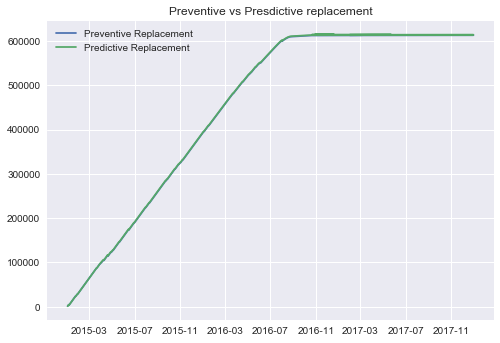

In [56]:
df_test = df.loc[test_data_mask, :]

dates = df_test.date.unique()
C = 1000
total_revenue = []

revenue = []
turned_off = set()

for ind, day in enumerate(dates) :
    df_day = df_test[df_test['date']==day]
    revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
    # With predictive replacement : Include here the HDDs predicted to fail to the set turned_off
    
cum_revenue = np.cumsum(revenue)
print('R with only preventive replacement = {}'.format(cum_revenue[-1]))

plt.plot(dates, cum_revenue, label = 'Preventive Replacement')

revenue = []
turned_off = set()
df_test['predictions'] = (rf.predict_proba(X_test)[:,1] > 0.8)

for ind, day in enumerate(dates) :
    df_day = df_test[df_test['date']==day]
    revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
    to_turn_off = df_day.loc[df_day['predictions'] == 1,'serial_number'].values
    if len(to_turn_off) > 0 :
        print(to_turn_off)
        turned_off.update(to_turn_off) 
    
cum_revenue = np.cumsum(revenue)
print('R with predictive replacement (RandomForest threshold 0.8) = {}'.format(cum_revenue[-1]))

plt.plot(dates, cum_revenue, label = 'Predictive Replacement')


plt.title('Preventive vs Presdictive replacement')
plt.legend()
plt.show()        
